필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

In [3]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.preprocessing import StandardScaler

데이터 가져오기

In [5]:
base_path = r"C:\Users\owner\Desktop\water-source\data"

In [6]:
scb_yearly = pd.read_excel(base_path+"\Seungchonbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [7]:
print(type(scb_yearly))  # type-dict
print(scb_yearly.keys())  # 2012년부터 2022년까지

<class 'dict'>
dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])


In [8]:
scb_yearly['2012년'].columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')

2013년 자료부터

In [9]:
scb_yearly_df13 = pd.DataFrame()

for item in list(scb_yearly.keys())[1:]:
    scb_yearly_df13 = pd.concat([scb_yearly_df13, scb_yearly[item]])

In [10]:
scb_yearly_df13 = scb_yearly_df13.reset_index(drop=True)

결측치 확인

In [11]:
scb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82257 entries, 0 to 82256
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
dtypes: float64(8), object(2)
memory usage: 6.3+ MB


In [12]:
scb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
수소이온농도         17696
전기전도도 μS/cm    17733
용존산소 mg/L      19601
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
dtype: int64

In [13]:
scb_yearly_df13.head()

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00h,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01h,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02h,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03h,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04h,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9


유량 데이터 추가하기

In [14]:
scb_flow_yearly = pd.read_excel(base_path+"\Seungchonbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [15]:
for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly[year]['연월일시'] = scb_flow_yearly[year]['시간'].apply(lambda x : x[:-3])

In [16]:
scb_flow_yearly_hour = {}

for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly_hour[year] = scb_flow_yearly[year].groupby('연월일시').mean()

In [17]:
for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour[year] = scb_flow_yearly_hour[year].reset_index()

In [18]:
scb_flow_yearly_hour_df = pd.DataFrame()

for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour_df = pd.concat([scb_flow_yearly_hour_df, scb_flow_yearly_hour[year]])

In [19]:
scb_flow_yearly_hour_df = scb_flow_yearly_hour_df.reset_index(drop=True)

In [20]:
print(scb_flow_yearly_hour_df.__len__())
print(scb_yearly_df13.__len__())

84393
82257


In [21]:
scb_yearly_df13['연월일시'] = scb_yearly_df13['측정일/월'].transform(lambda x: x.strip('h').replace('-', '.'))

In [22]:
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, how='outer')

In [23]:
scb_data = scb_data[:82257]

In [24]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82257 entries, 0 to 82256
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
 10  연월일시         82257 non-null  object 
 11   상류수위(EL.m)  82231 non-null  float64
 12   하류수위(EL.m)  82231 non-null  float64
 13   유입량(㎥/s)    82231 non-null  float64
 14   방류량(㎥/s)    82231 non-null  float64
dtypes: float64(12), object(3)
memory usage: 10.0+ MB


In [25]:
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

In [26]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82257 entries, 0 to 82256
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
 10  연월일시         82257 non-null  object 
 11  상류수위(EL.m)   82231 non-null  float64
 12  하류수위(EL.m)   82231 non-null  float64
 13  유입량(㎥/s)     82231 non-null  float64
 14  방류량(㎥/s)     82231 non-null  float64
dtypes: float64(12), object(3)
memory usage: 10.0+ MB


In [27]:
scb_data = scb_data.loc[:, list(scb_data.columns)[:3]  + list(scb_data.columns)[4:5] + list(scb_data.columns)[6:-5] + list(scb_data.columns)[-4:-3] + list(scb_data.columns)[-1:]]

In [28]:
scb_data.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [29]:
scb_data.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
전기전도도 μS/cm    17733
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
상류수위(EL.m)        26
방류량(㎥/s)          26
dtype: int64

In [30]:
scb_data.isnull().sum() /len(scb_data)

측정일/월          0.000000
측정소명           0.000000
수온 ℃           0.214973
전기전도도 μS/cm    0.215580
총유기탄소 mg/L     0.286687
총질소 mg/L       0.270810
총인 mg/L        0.282772
클로로필-a mg/㎥    0.235615
상류수위(EL.m)     0.000316
방류량(㎥/s)       0.000316
dtype: float64

In [31]:
len(scb_data)

82257

시간데이터 추가

In [32]:
scb_df = scb_data.copy()

In [33]:
scb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [34]:
col_c = list(scb_df.columns.copy())
col_c.remove('클로로필-a mg/㎥')

In [35]:
col_c

['측정일/월',
 '측정소명',
 '수온 ℃',
 '전기전도도 μS/cm',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [36]:
for i in range(1, 49):
    scb_df[str(i) + 'shift 총질소'] = scb_df['총질소 mg/L'].shift(i)

In [37]:
len(scb_df)

82257

In [38]:
scb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 총질소',
       '2shift 총질소', '3shift 총질소', '4shift 총질소', '5shift 총질소', '6shift 총질소',
       '7shift 총질소', '8shift 총질소', '9shift 총질소', '10shift 총질소', '11shift 총질소',
       '12shift 총질소', '13shift 총질소', '14shift 총질소', '15shift 총질소',
       '16shift 총질소', '17shift 총질소', '18shift 총질소', '19shift 총질소',
       '20shift 총질소', '21shift 총질소', '22shift 총질소', '23shift 총질소',
       '24shift 총질소', '25shift 총질소', '26shift 총질소', '27shift 총질소',
       '28shift 총질소', '29shift 총질소', '30shift 총질소', '31shift 총질소',
       '32shift 총질소', '33shift 총질소', '34shift 총질소', '35shift 총질소',
       '36shift 총질소', '37shift 총질소', '38shift 총질소', '39shift 총질소',
       '40shift 총질소', '41shift 총질소', '42shift 총질소', '43shift 총질소',
       '44shift 총질소', '45shift 총질소', '46shift 총질소', '47shift 총질소',
       '48shift 총질소'],
      dtype='object')

In [39]:
len(scb_df)

82257

결측치 보간법

In [40]:
from datetime import datetime

In [41]:
scb_df = scb_df.copy()

In [42]:
scb_df['측정일/월'] = scb_df['측정일/월'].transform(lambda x: datetime.strptime(x[:-1], '%Y-%m-%d %H'))

In [43]:
scb_df = scb_df.copy().set_index('측정일/월').interpolate(method='time')

In [44]:
scb_df = scb_df.dropna()

In [45]:
scb_df.__len__()

80106

In [46]:
scb_df.columns

Index(['측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 총질소', '2shift 총질소',
       '3shift 총질소', '4shift 총질소', '5shift 총질소', '6shift 총질소', '7shift 총질소',
       '8shift 총질소', '9shift 총질소', '10shift 총질소', '11shift 총질소', '12shift 총질소',
       '13shift 총질소', '14shift 총질소', '15shift 총질소', '16shift 총질소',
       '17shift 총질소', '18shift 총질소', '19shift 총질소', '20shift 총질소',
       '21shift 총질소', '22shift 총질소', '23shift 총질소', '24shift 총질소',
       '25shift 총질소', '26shift 총질소', '27shift 총질소', '28shift 총질소',
       '29shift 총질소', '30shift 총질소', '31shift 총질소', '32shift 총질소',
       '33shift 총질소', '34shift 총질소', '35shift 총질소', '36shift 총질소',
       '37shift 총질소', '38shift 총질소', '39shift 총질소', '40shift 총질소',
       '41shift 총질소', '42shift 총질소', '43shift 총질소', '44shift 총질소',
       '45shift 총질소', '46shift 총질소', '47shift 총질소', '48shift 총질소'],
      dtype='object')

In [47]:
scb_df.head()

,측정소명,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),1shift 총질소,...,39shift 총질소,40shift 총질소,41shift 총질소,42shift 총질소,43shift 총질소,44shift 총질소,45shift 총질소,46shift 총질소,47shift 총질소,48shift 총질소
측정일/월,,,,,,,,,,,,,,,,,,,,,
2013-03-31 16:00:00,용봉,14.0,326.0,3.4,6.847,0.102,41.0,7.52,12.426667,6.748,...,6.042,6.040,6.013,5.970,5.847,5.812,5.822,5.809,5.850,5.866
2013-03-31 17:00:00,용봉,14.0,329.0,3.4,6.967,0.102,42.4,7.52,12.426667,6.847,...,6.110,6.042,6.040,6.013,5.970,5.847,5.812,5.822,5.809,5.850
2013-03-31 18:00:00,용봉,13.6,328.0,3.4,7.094,0.101,40.1,7.52,12.390000,6.967,...,6.380,6.110,6.042,6.040,6.013,5.970,5.847,5.812,5.822,5.809
2013-03-31 19:00:00,용봉,13.4,330.0,3.4,7.146,0.099,39.7,7.52,12.383333,7.094,...,6.498,6.380,6.110,6.042,6.040,6.013,5.970,5.847,5.812,5.822
2013-03-31 20:00:00,용봉,13.3,333.0,3.4,7.038,0.098,39.4,7.52,12.370000,7.146,...,6.278,6.498,6.380,6.110,6.042,6.040,6.013,5.970,5.847,5.812


In [48]:
col = list(scb_df.columns[1:])
#print(col)

In [49]:
col_v = col.copy()
col_v.remove('클로로필-a mg/㎥')
#print(col_v)

피처 정규화 없이

In [50]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_v], scb_df['클로로필-a mg/㎥'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [51]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3)

In [52]:
gb_grid.fit(X_train, np.log1p(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [53]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [54]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.932759,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.930875,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.929169,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.928945,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.923595,5


In [55]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [56]:
estimator = gb_grid.best_estimator_

In [57]:
pred = estimator.predict(X_test)

In [58]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.19 수온 ℃
0.25 전기전도도 μS/cm
0.06 총유기탄소 mg/L
0.02 총질소 mg/L
0.07 총인 mg/L
0.13 상류수위(EL.m)
0.11 방류량(㎥/s)
0.01 1shift 총질소
0.0 2shift 총질소
0.01 3shift 총질소
0.0 4shift 총질소
0.0 5shift 총질소
0.01 6shift 총질소
0.0 7shift 총질소
0.0 8shift 총질소
0.0 9shift 총질소
0.0 10shift 총질소
0.0 11shift 총질소
0.0 12shift 총질소
0.0 13shift 총질소
0.0 14shift 총질소
0.0 15shift 총질소
0.02 16shift 총질소
0.0 17shift 총질소
0.0 18shift 총질소
0.0 19shift 총질소
0.0 20shift 총질소
0.0 21shift 총질소
0.0 22shift 총질소
0.0 23shift 총질소
0.0 24shift 총질소
0.0 25shift 총질소
0.0 26shift 총질소
0.0 27shift 총질소
0.0 28shift 총질소
0.0 29shift 총질소
0.0 30shift 총질소
0.0 31shift 총질소
0.0 32shift 총질소
0.0 33shift 총질소
0.0 34shift 총질소
0.0 35shift 총질소
0.0 36shift 총질소
0.0 37shift 총질소
0.0 38shift 총질소
0.0 39shift 총질소
0.0 40shift 총질소
0.0 41shift 총질소
0.0 42shift 총질소
0.0 43shift 총질소
0.0 44shift 총질소
0.0 45shift 총질소
0.0 46shift 총질소
0.01 47shift 총질소
0.01 48shift 총질소


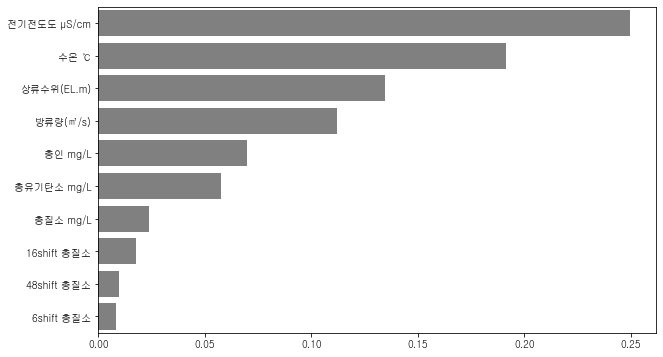

In [59]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [60]:
feature_series[:10]

전기전도도 μS/cm    0.249339
수온 ℃           0.191466
상류수위(EL.m)     0.134761
방류량(㎥/s)       0.112133
총인 mg/L        0.069979
총유기탄소 mg/L     0.057403
총질소 mg/L       0.024056
16shift 총질소    0.017952
48shift 총질소    0.009590
6shift 총질소     0.008506
dtype: float64

In [61]:
print('score :', estimator.score(X_test, np.log1p(y_test)))

score : 0.953870347995281


피처 정규화

In [62]:
scaler = StandardScaler()
scaler.fit(scb_df.loc[:, col_v])
scb_scaled = scaler.transform(scb_df.loc[:, col_v])

scb_df_scaled = pd.DataFrame(data = scb_scaled, columns = col_v)

In [63]:
scb_df_scaled.head()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,상류수위(EL.m),방류량(㎥/s),1shift 총질소,2shift 총질소,3shift 총질소,...,39shift 총질소,40shift 총질소,41shift 총질소,42shift 총질소,43shift 총질소,44shift 총질소,45shift 총질소,46shift 총질소,47shift 총질소,48shift 총질소
0,-0.460123,-0.204436,-1.066592,0.701736,-0.404844,0.712847,-0.173164,0.651838,0.656368,0.666943,...,0.295979,0.294983,0.281388,0.259727,0.197748,0.180117,0.185164,0.178620,0.199291,0.207364
1,-0.460123,-0.170395,-1.066592,0.762211,-0.404844,0.712847,-0.173164,0.701730,0.651832,0.656360,...,0.330248,0.295991,0.294994,0.281397,0.259735,0.197756,0.180124,0.185171,0.178628,0.199300
2,-0.512399,-0.181742,-1.066592,0.826214,-0.419518,0.712847,-0.173485,0.762205,0.701724,0.651824,...,0.466315,0.330260,0.296002,0.295004,0.281406,0.259743,0.197763,0.180132,0.185180,0.178637
3,-0.538537,-0.159048,-1.066592,0.852420,-0.448867,0.712847,-0.173544,0.826208,0.762199,0.701716,...,0.525781,0.466328,0.330271,0.296012,0.295013,0.281414,0.259751,0.197770,0.180140,0.185189
4,-0.551606,-0.125007,-1.066592,0.797992,-0.463541,0.712847,-0.173661,0.852414,0.826202,0.762191,...,0.414912,0.525794,0.466340,0.330281,0.296021,0.295021,0.281421,0.259758,0.197779,0.180149


In [64]:
X_trains, X_tests, y_trains, y_tests = train_test_split(scb_df_scaled.loc[:, col_v], scb_df['클로로필-a mg/㎥'], random_state=42)
gb_regs = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [65]:
gb_grids = GridSearchCV(gb_regs, param_grid=parameters, cv=3)

In [66]:
gb_grids.fit(X_trains, np.log1p(y_trains))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [67]:
scores_dfs = pd.DataFrame(gb_grids.cv_results_)

In [68]:
scores_dfs.sort_values(by=['rank_test_score'], inplace=True)
scores_dfs[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.932793,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.930885,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.929187,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.928935,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.923584,5


In [69]:
gb_grids.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [70]:
estimators = gb_grids.best_estimator_

In [71]:
preds = estimators.predict(X_tests)

In [72]:
for score, name in zip(estimators.feature_importances_, col_v):
    print(round(score, 2), name)

0.19 수온 ℃
0.25 전기전도도 μS/cm
0.06 총유기탄소 mg/L
0.02 총질소 mg/L
0.07 총인 mg/L
0.13 상류수위(EL.m)
0.11 방류량(㎥/s)
0.01 1shift 총질소
0.0 2shift 총질소
0.01 3shift 총질소
0.0 4shift 총질소
0.0 5shift 총질소
0.01 6shift 총질소
0.0 7shift 총질소
0.0 8shift 총질소
0.0 9shift 총질소
0.0 10shift 총질소
0.0 11shift 총질소
0.0 12shift 총질소
0.0 13shift 총질소
0.0 14shift 총질소
0.0 15shift 총질소
0.02 16shift 총질소
0.0 17shift 총질소
0.0 18shift 총질소
0.0 19shift 총질소
0.0 20shift 총질소
0.0 21shift 총질소
0.0 22shift 총질소
0.0 23shift 총질소
0.0 24shift 총질소
0.0 25shift 총질소
0.0 26shift 총질소
0.0 27shift 총질소
0.0 28shift 총질소
0.0 29shift 총질소
0.0 30shift 총질소
0.0 31shift 총질소
0.0 32shift 총질소
0.0 33shift 총질소
0.0 34shift 총질소
0.0 35shift 총질소
0.0 36shift 총질소
0.0 37shift 총질소
0.0 38shift 총질소
0.0 39shift 총질소
0.0 40shift 총질소
0.0 41shift 총질소
0.0 42shift 총질소
0.0 43shift 총질소
0.0 44shift 총질소
0.0 45shift 총질소
0.0 46shift 총질소
0.01 47shift 총질소
0.01 48shift 총질소


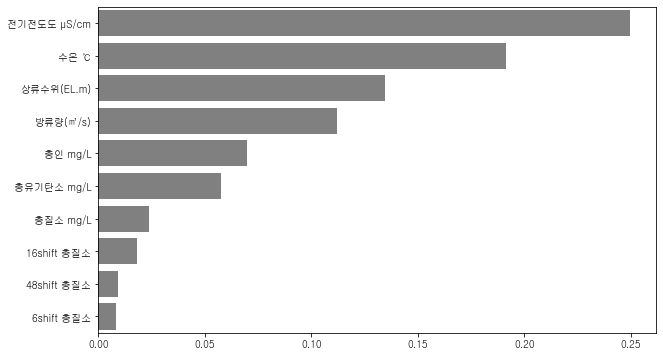

In [73]:
feature_seriess = pd.Series(data = estimators.feature_importances_, index = col_v)
feature_seriess = feature_seriess.sort_values(ascending = False)
sns.barplot(x = feature_seriess[:10], y = feature_seriess.index[:10], color = 'gray')
plt.show()

In [74]:
feature_seriess[:10]

전기전도도 μS/cm    0.249383
수온 ℃           0.191473
상류수위(EL.m)     0.134765
방류량(㎥/s)       0.112146
총인 mg/L        0.069914
총유기탄소 mg/L     0.057401
총질소 mg/L       0.024069
16shift 총질소    0.017985
48shift 총질소    0.009520
6shift 총질소     0.008493
dtype: float64

In [75]:
print('score :', estimators.score(X_tests, np.log1p(y_tests)))

score : 0.9541655960225152
